Total de registros: 39,702
Período: 2000-01-12 a 2025-02-28
Número de estaciones: 1
Porcentaje de heladas: 32.17%


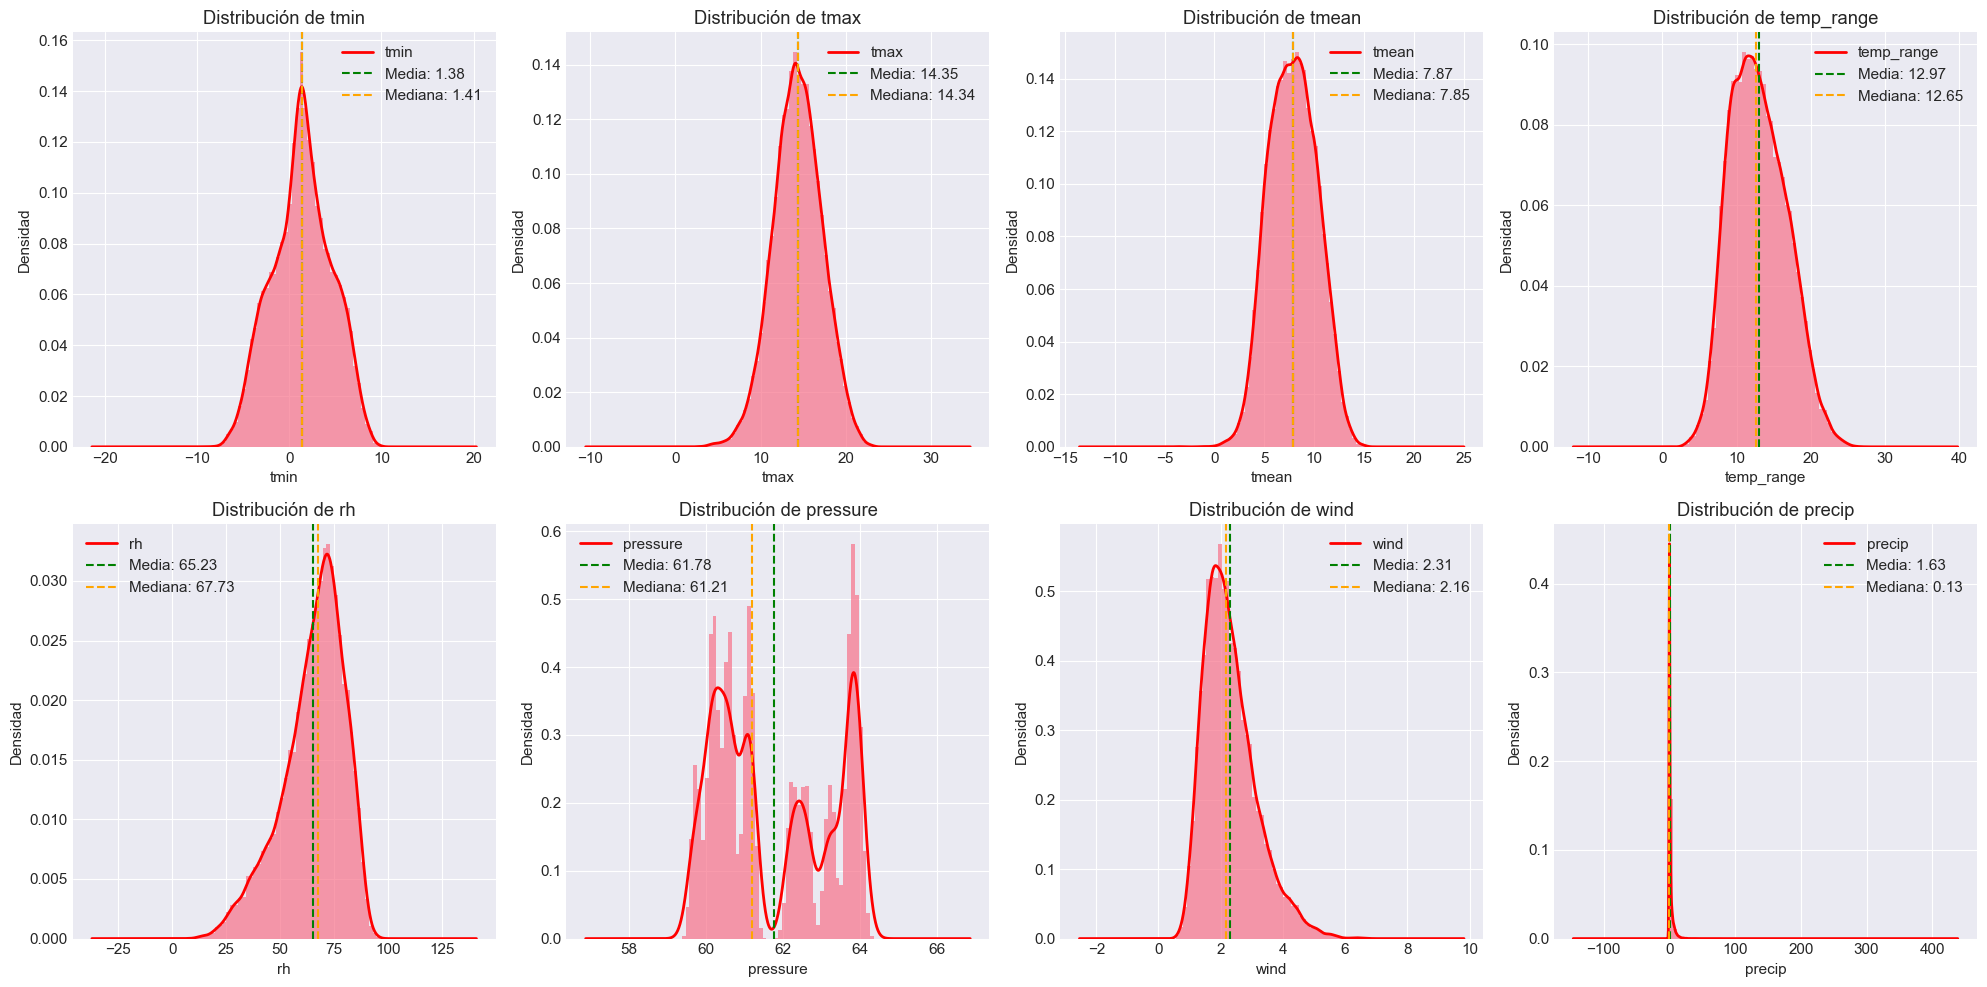

Test de Normalidad (Shapiro-Wilk):
--------------------------------------------------
tmin            | p-value: 0.0000 | Normal: No
tmax            | p-value: 0.0001 | Normal: No
tmean           | p-value: 0.0000 | Normal: No
temp_range      | p-value: 0.0000 | Normal: No
rh              | p-value: 0.0000 | Normal: No
pressure        | p-value: 0.0000 | Normal: No
wind            | p-value: 0.0000 | Normal: No
precip          | p-value: 0.0000 | Normal: No


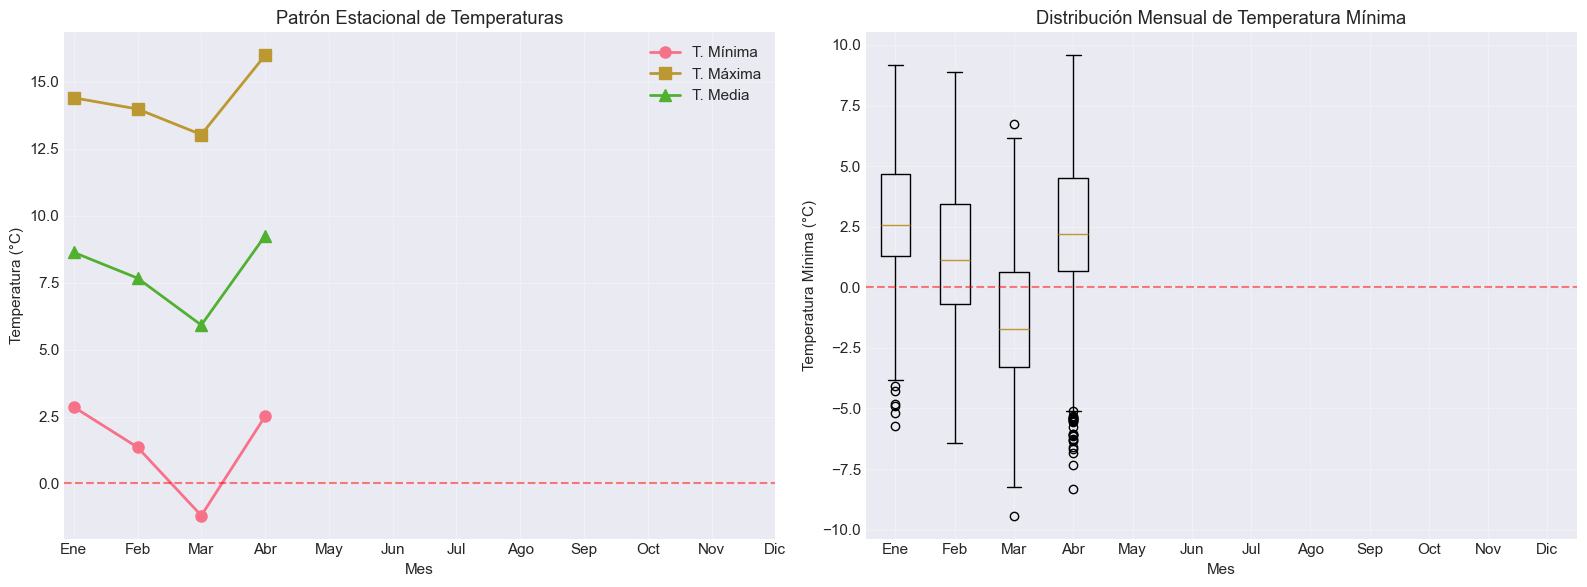

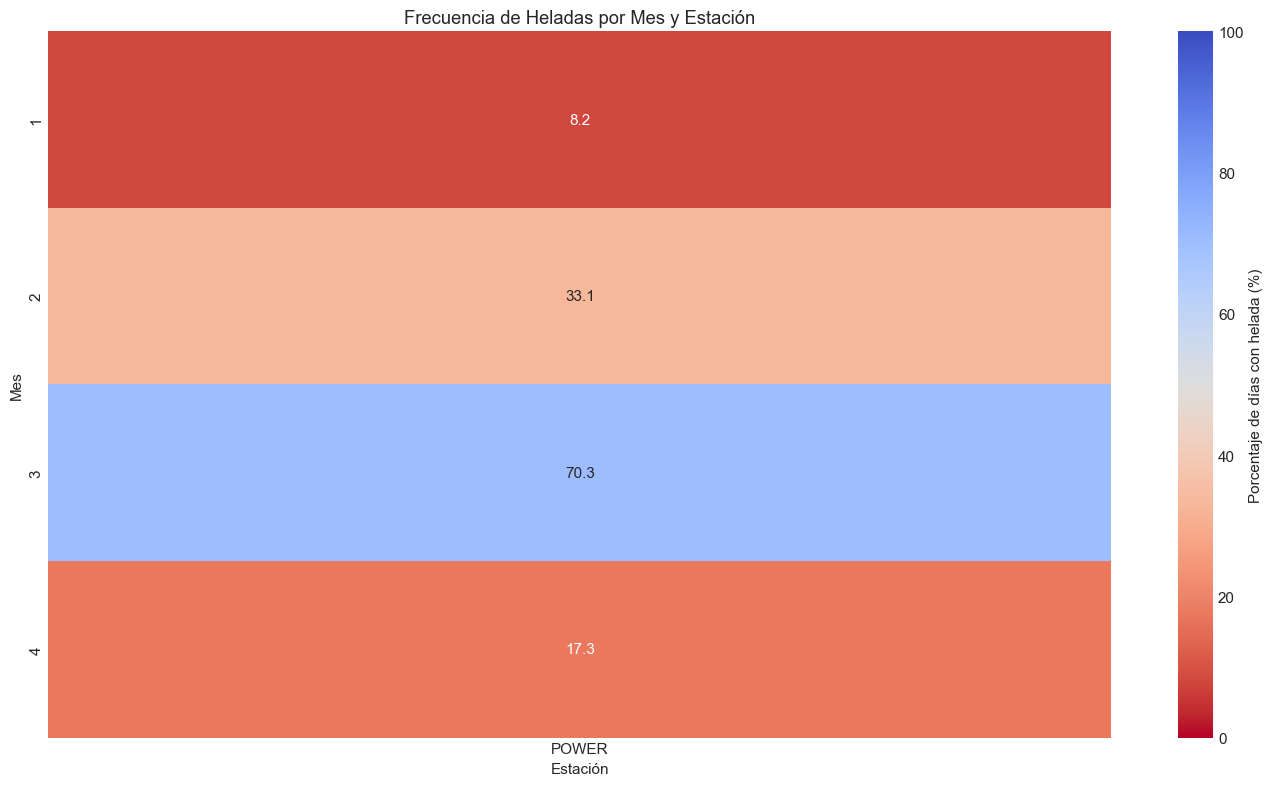

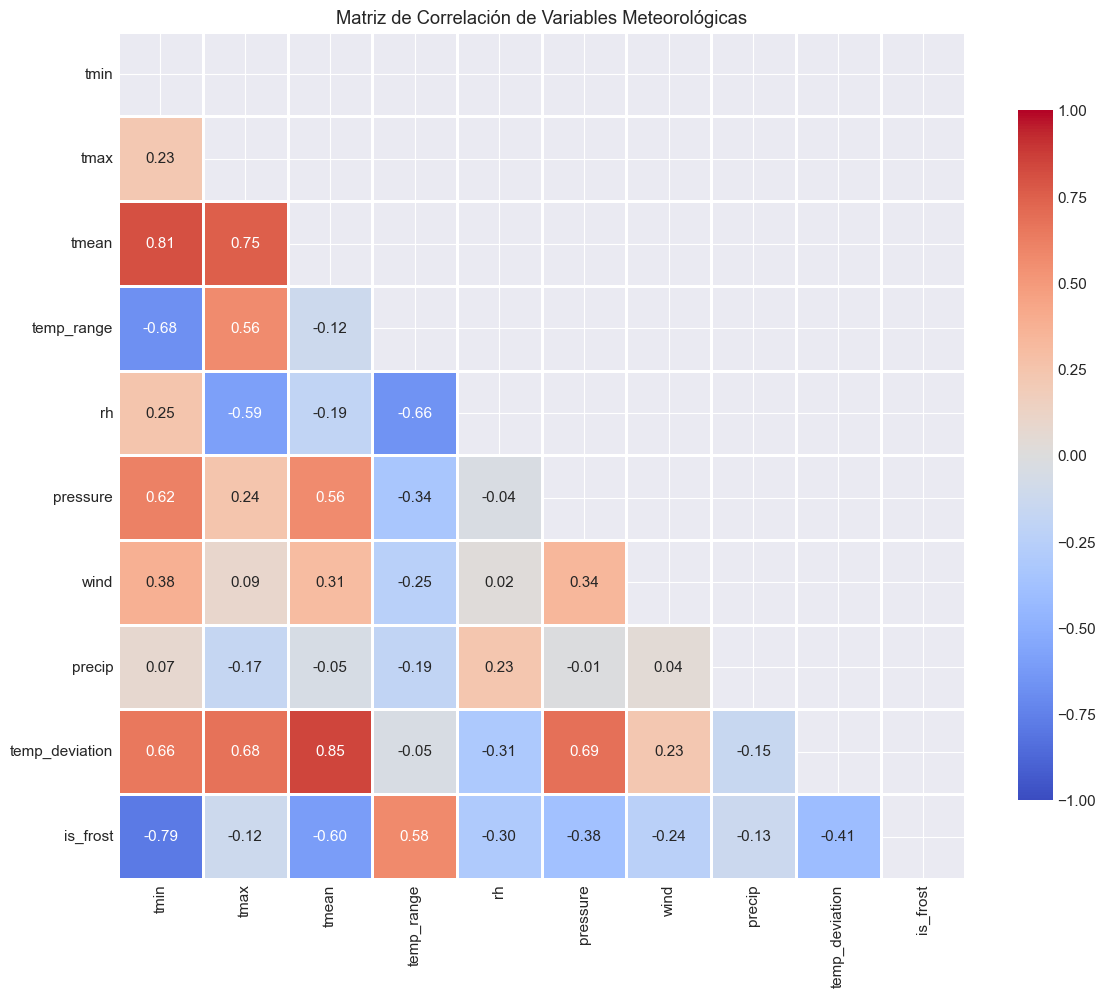

Correlaciones con Temperatura Mínima:
tmin              1.000
tmean             0.811
temp_deviation    0.655
pressure          0.616
wind              0.376
rh                0.248
tmax              0.226
precip            0.075
temp_range       -0.677
is_frost         -0.788
Name: tmin, dtype: float64


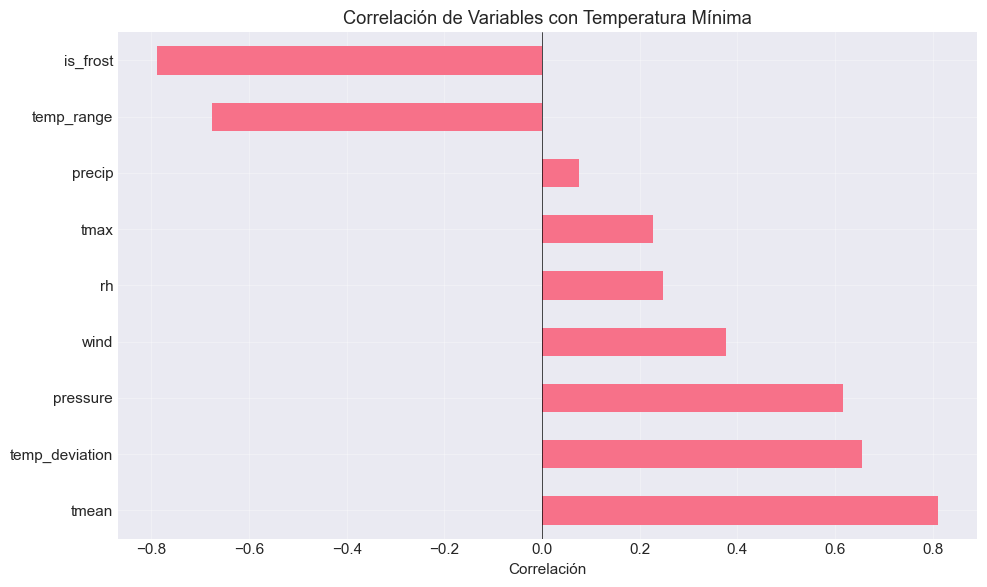

Eventos extremos (T ≤ -10°C): 2 (0.01%)
Heladas moderadas (-10°C < T ≤ 0°C): 12771 (32.17%)
Sin helada (T > 0°C): 26929 (67.83%)


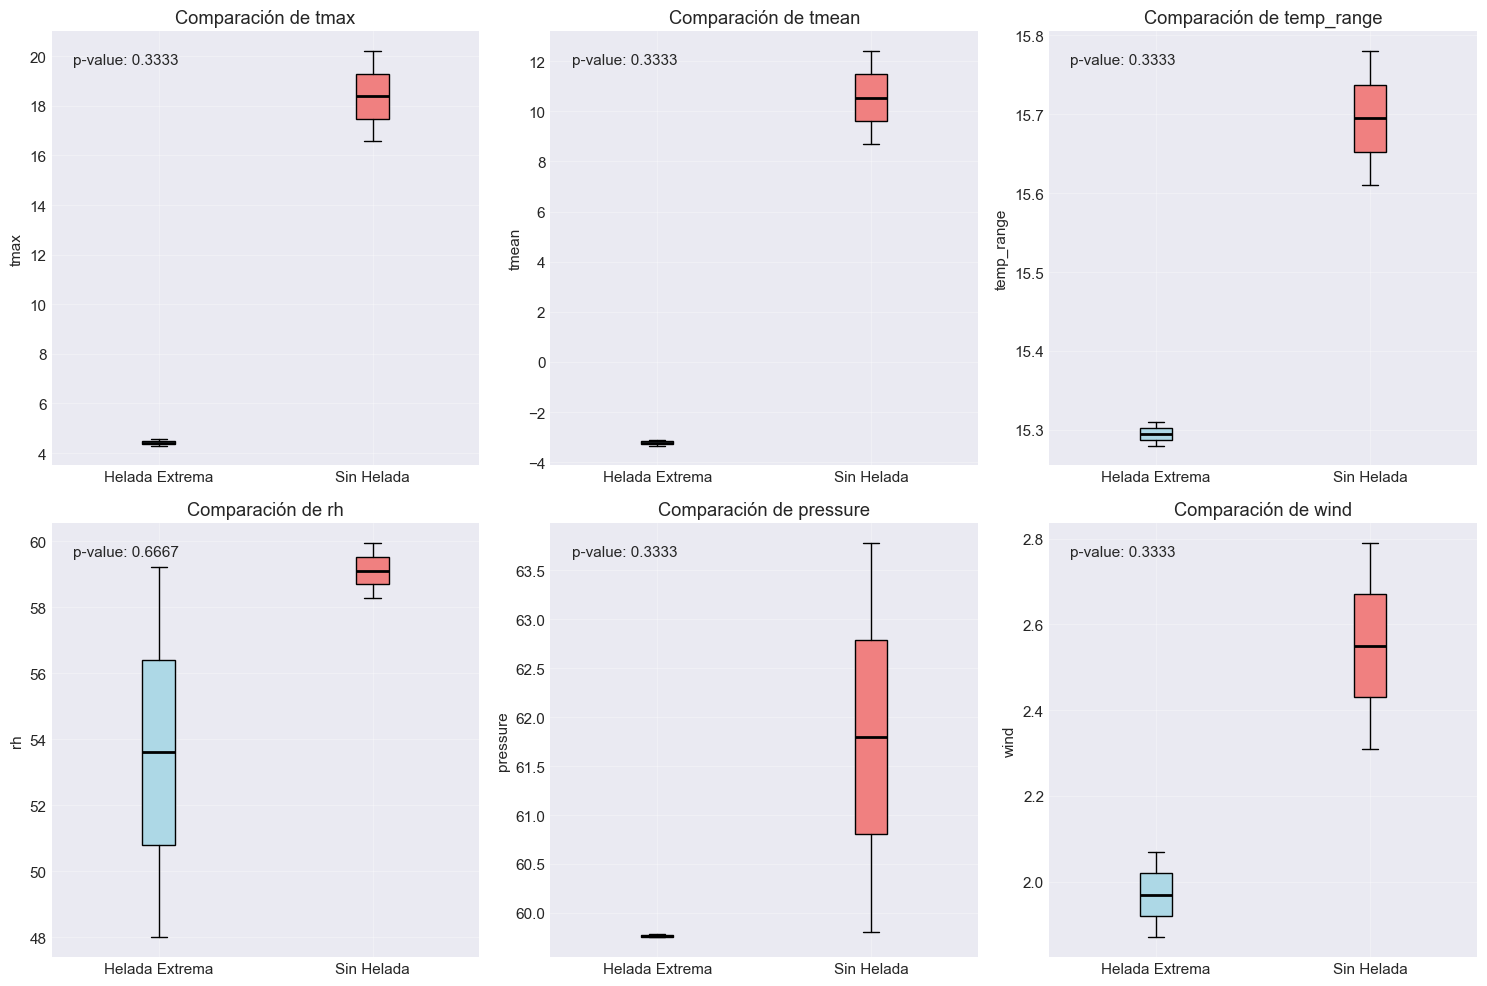

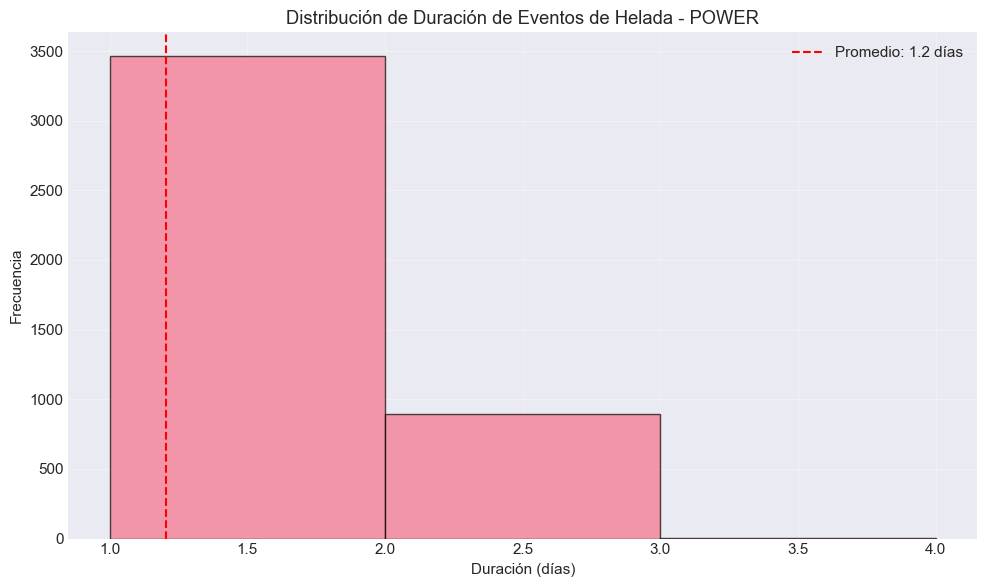

Estadísticas por Estación:
  station  tmin_mean  tmin_min  tmin_std  tmax_mean  tmax_max  is_frost_sum  \
0   POWER       1.38    -10.98      3.22      14.35     23.32         12773   

   is_frost_mean  temp_range_mean  
0           0.32            12.97  


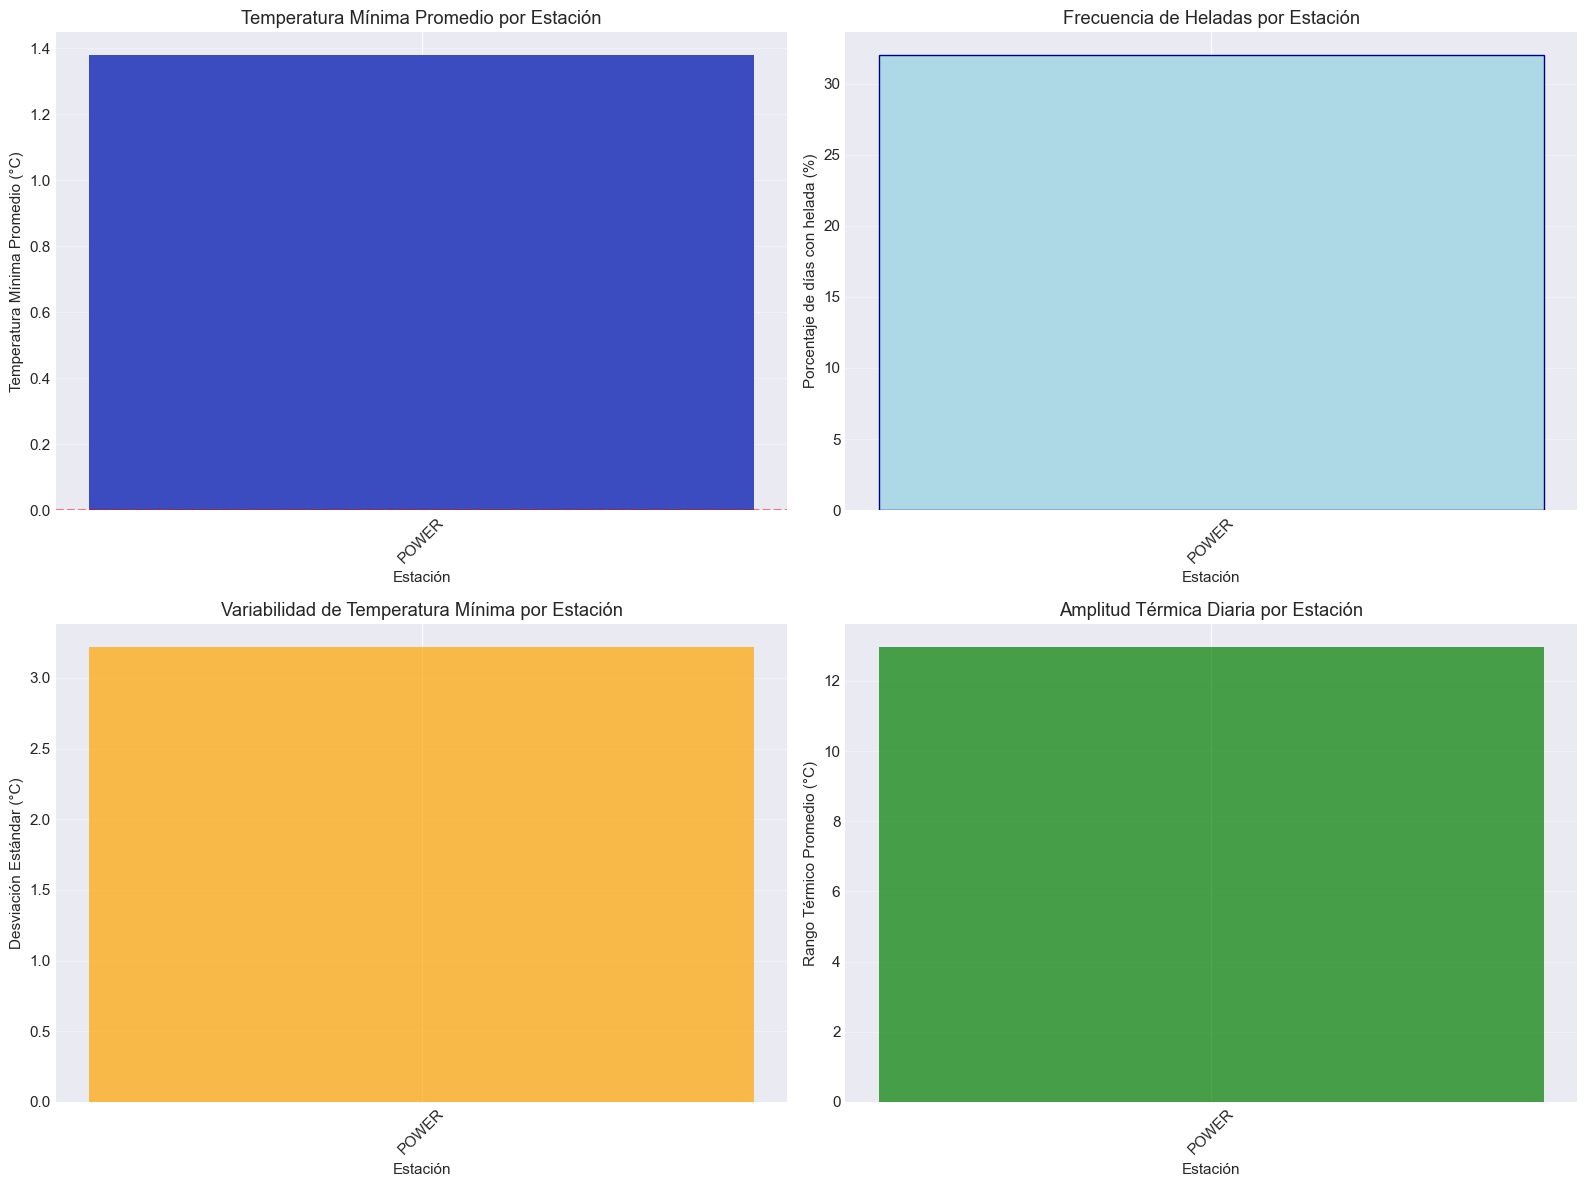

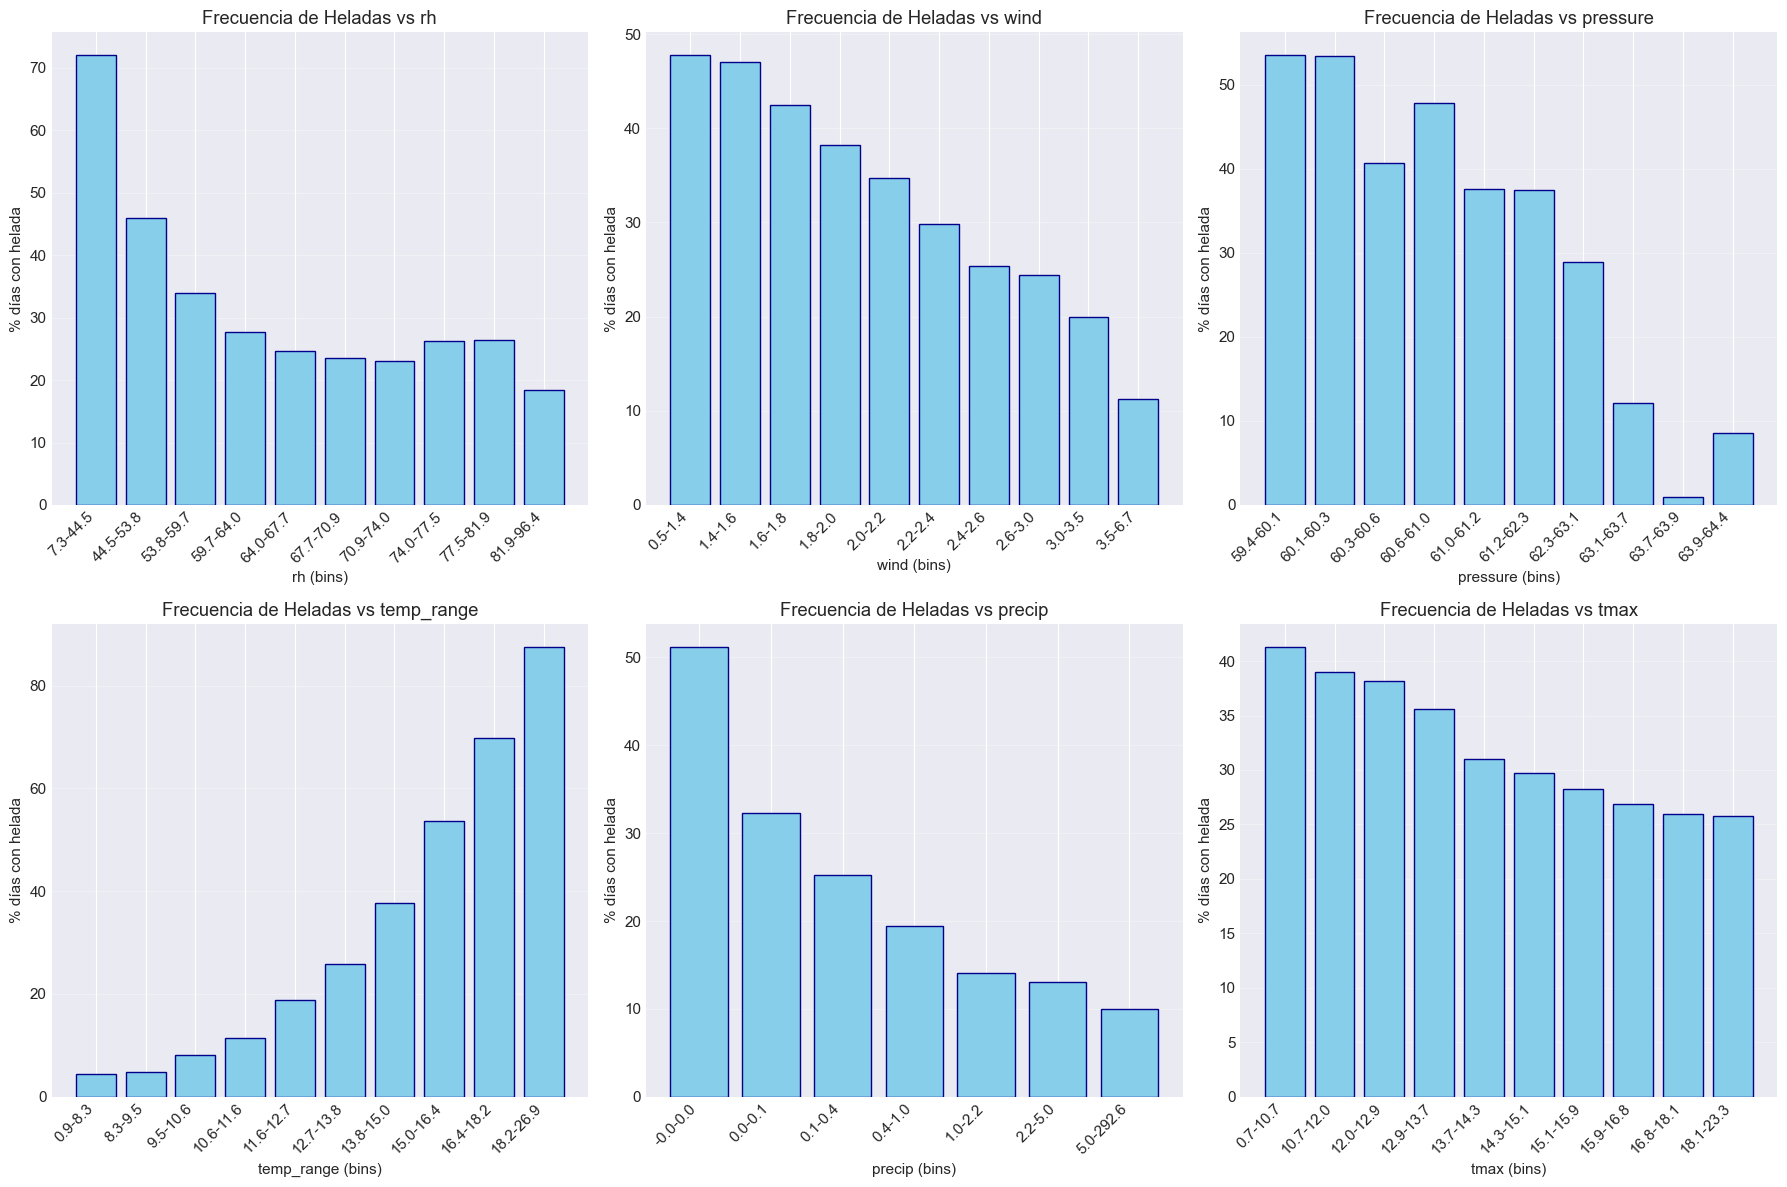

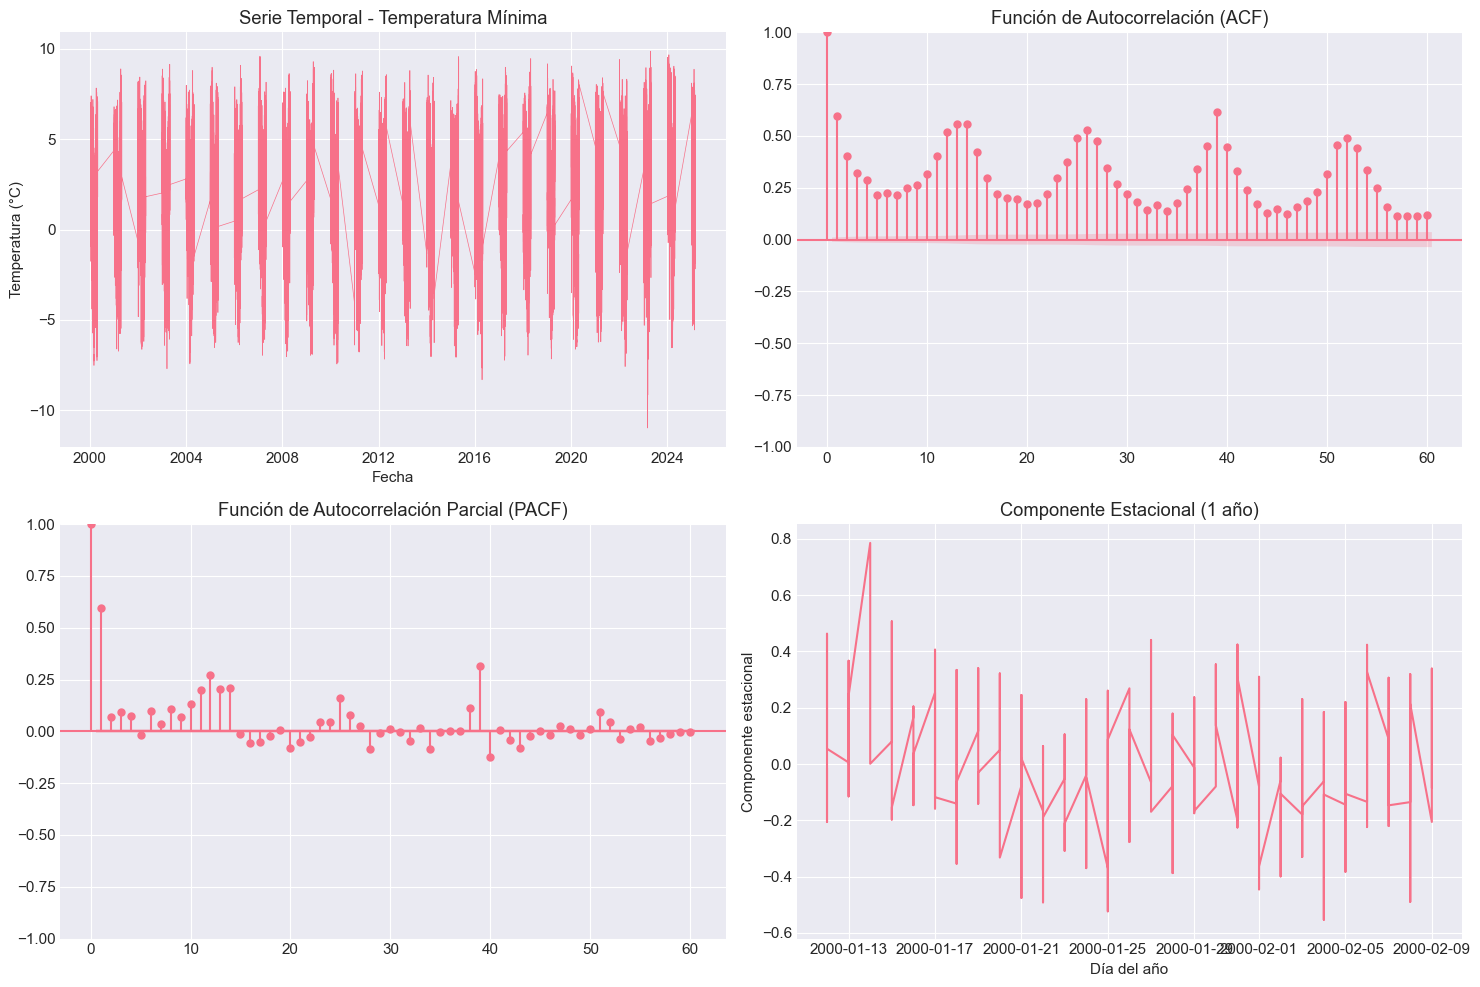

RESUMEN DE INSIGHTS CLAVE PARA MODELADO

1. DISTRIBUCIÓN DE CLASES:
   - Sin helada: 26,929 (67.8%)
   - Con helada: 12,773 (32.2%)
   → Datos desbalanceados: considerar técnicas de balanceo o métricas apropiadas

2. ESTACIONALIDAD:
   - Meses con más heladas: [3, 2, 4] (invierno austral)
   - Fuerte componente estacional → incluir features estacionales

3. VARIABLES MÁS IMPORTANTES:
   - tmean: r = 0.811
   - is_frost: r = -0.788
   - temp_range: r = -0.677
   - temp_deviation: r = 0.655
   - pressure: r = 0.616

4. EVENTOS EXTREMOS:
   - 2 eventos con T ≤ -10°C
   - Condiciones típicas: baja humedad, alto rango térmico, presión alta

5. VARIABILIDAD ESPACIAL:
   - Estaciones con más heladas: ['POWER']
   - Considerar modelos específicos por estación o clusters

6. DEPENDENCIA TEMPORAL:
   - Fuerte autocorrelación hasta 7 días
   - Patrón anual claro (período = 365 días)

Análisis completo. Resumen guardado en results/eda_summary.json


In [1]:
# %% [markdown]
# # 02. Análisis Exploratorio de Datos (EDA) - Pronóstico de Heladas

# %% [markdown]
# ## 1. Configuración inicial y carga de datos

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

pd.set_option('display.max_columns', 50)
pd.set_option('display.precision', 3)

# %%
train_data = pd.read_csv('../data/processed/train_data.csv', parse_dates=['date'])
val_data = pd.read_csv('../data/processed/val_data.csv', parse_dates=['date'])
test_data = pd.read_csv('../data/processed/test_data.csv', parse_dates=['date'])

df = pd.concat([train_data, val_data, test_data], ignore_index=True)

# Asegúrate de tener tmean (por si acaso)
if 'tmean' not in df.columns:
    df['tmean'] = (df['tmin'] + df['tmax']) / 2

print(f"Total de registros: {len(df):,}")
print(f"Período: {df['date'].min().strftime('%Y-%m-%d')} a {df['date'].max().strftime('%Y-%m-%d')}")
print(f"Número de estaciones: {df['station'].nunique()}")
print(f"Porcentaje de heladas: {df['is_frost'].mean()*100:.2f}%")

# %% [markdown]
# ## 2. Análisis de Distribuciones

# %%
main_vars = ['tmin', 'tmax', 'tmean', 'temp_range', 'rh', 'pressure', 'wind', 'precip']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, var in enumerate(main_vars):
    if var in df.columns:
        ax = axes[i]
        df[var].hist(bins=50, ax=ax, alpha=0.7, density=True)
        df[var].plot(kind='kde', ax=ax, color='red', linewidth=2)
        mean_val = df[var].mean()
        median_val = df[var].median()
        ax.axvline(mean_val, color='green', linestyle='--', label=f'Media: {mean_val:.2f}')
        ax.axvline(median_val, color='orange', linestyle='--', label=f'Mediana: {median_val:.2f}')
        ax.set_title(f'Distribución de {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Densidad')
        ax.legend()

plt.tight_layout()
plt.savefig('../results/figures/distributions_main_variables.png', dpi=300)
plt.show()

# %%
print("Test de Normalidad (Shapiro-Wilk):")
print("-" * 50)
for var in main_vars:
    if var in df.columns:
        sample = df[var].dropna().sample(min(5000, len(df)))
        stat, p_value = stats.shapiro(sample)
        print(f"{var:15} | p-value: {p_value:.4f} | Normal: {'No' if p_value < 0.05 else 'Sí'}")

# %% [markdown]
# ## 3. Análisis de Patrones Temporales

# %%
fig = make_subplots(rows=3, cols=1, 
                    subplot_titles=('Temperatura Mínima Diaria', 
                                'Promedio Mensual', 
                                'Tendencia Anual'),
                    vertical_spacing=0.1)

sample_year = df[df['year'] == 2020]
fig.add_trace(
    go.Scatter(x=sample_year['date'], 
            y=sample_year['tmin'],
            mode='lines',
            name='T. Mínima Diaria',
            line=dict(color='blue', width=1)),
    row=1, col=1
)
fig.add_hline(y=0, line_dash="dash", line_color="red", row=1, col=1)

monthly_avg = df.groupby(['year', 'month'])['tmin'].mean().reset_index()
monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))
fig.add_trace(
    go.Scatter(x=monthly_avg['date'], 
            y=monthly_avg['tmin'],
            mode='lines+markers',
            name='Promedio Mensual',
            line=dict(color='green', width=2)),
    row=2, col=1
)

annual_avg = df.groupby('year')['tmin'].agg(['mean', 'min', 'max']).reset_index()
fig.add_trace(
    go.Scatter(x=annual_avg['year'], 
            y=annual_avg['mean'],
            mode='lines+markers',
            name='Media Anual',
            line=dict(color='orange', width=3)),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=annual_avg['year'], 
            y=annual_avg['min'],
            mode='lines',
            name='Mínimo Anual',
            line=dict(color='red', width=1, dash='dash')),
    row=3, col=1
)

fig.update_layout(height=900, showlegend=True, 
                title_text="Análisis Temporal de Temperatura Mínima")
fig.update_xaxes(title_text="Fecha", row=3, col=1)
fig.update_yaxes(title_text="Temperatura (°C)")

fig.write_html('../results/figures/temporal_patterns.html')
fig.show()

# %%
seasonal_pattern = df.groupby(['month', 'station'])['tmin'].mean().reset_index()
seasonal_avg = df.groupby('month')[['tmin', 'tmax', 'tmean']].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
        'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

ax1.plot(seasonal_avg['month'], seasonal_avg['tmin'], 'o-', label='T. Mínima', linewidth=2, markersize=8)
ax1.plot(seasonal_avg['month'], seasonal_avg['tmax'], 's-', label='T. Máxima', linewidth=2, markersize=8)
ax1.plot(seasonal_avg['month'], seasonal_avg['tmean'], '^-', label='T. Media', linewidth=2, markersize=8)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.set_xlabel('Mes')
ax1.set_ylabel('Temperatura (°C)')
ax1.set_title('Patrón Estacional de Temperaturas')
ax1.legend()
ax1.grid(True, alpha=0.3)

df_sample = df.sample(min(10000, len(df)))
ax2.boxplot([df_sample[df_sample['month'] == m]['tmin'].values for m in range(1, 13)],
            labels=months)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Mes')
ax2.set_ylabel('Temperatura Mínima (°C)')
ax2.set_title('Distribución Mensual de Temperatura Mínima')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/seasonal_patterns.png', dpi=300)
plt.show()

# %%
frost_monthly = df.groupby(['month', 'station'])['is_frost'].mean().reset_index()
frost_pivot = frost_monthly.pivot(index='month', columns='station', values='is_frost')

plt.figure(figsize=(14, 8))
sns.heatmap(frost_pivot * 100, 
            cmap='coolwarm_r', 
            annot=True, 
            fmt='.1f',
            cbar_kws={'label': 'Porcentaje de días con helada (%)'},
            vmin=0, vmax=100)
plt.title('Frecuencia de Heladas por Mes y Estación')
plt.xlabel('Estación')
plt.ylabel('Mes')
plt.tight_layout()
plt.savefig('../results/figures/frost_heatmap_by_station_month.png', dpi=300)
plt.show()

# %% [markdown]
# ## 4. Análisis de Correlaciones

# %%
corr_vars = ['tmin', 'tmax', 'tmean', 'temp_range', 'rh', 'pressure', 'wind', 
            'precip', 'temp_deviation', 'is_frost']

corr_matrix = df[corr_vars].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación de Variables Meteorológicas')
plt.tight_layout()
plt.savefig('../results/figures/correlation_matrix.png', dpi=300)
plt.show()

# %%
target_corr = df[corr_vars].corr()['tmin'].sort_values(ascending=False)
print("Correlaciones con Temperatura Mínima:")
print(target_corr)

plt.figure(figsize=(10, 6))
target_corr[1:].plot(kind='barh')
plt.xlabel('Correlación')
plt.title('Correlación de Variables con Temperatura Mínima')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/target_correlations.png', dpi=300)
plt.show()

# %% [markdown]
# ## 5. Análisis de Eventos Extremos

# %%
extreme_cold = df['tmin'] <= -10
moderate_frost = (df['tmin'] > -10) & (df['tmin'] <= 0)
no_frost = df['tmin'] > 0

print(f"Eventos extremos (T ≤ -10°C): {extreme_cold.sum()} ({extreme_cold.mean()*100:.2f}%)")
print(f"Heladas moderadas (-10°C < T ≤ 0°C): {moderate_frost.sum()} ({moderate_frost.mean()*100:.2f}%)")
print(f"Sin helada (T > 0°C): {no_frost.sum()} ({no_frost.mean()*100:.2f}%)")

# %%
extreme_conditions = df[extreme_cold].copy()
normal_conditions = df[no_frost].sample(len(extreme_conditions))

variables_compare = ['tmax', 'tmean', 'temp_range', 'rh', 'pressure', 'wind']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, var in enumerate(variables_compare):
    ax = axes[i]
    data_to_plot = [extreme_conditions[var].dropna(), normal_conditions[var].dropna()]
    bp = ax.boxplot(data_to_plot, labels=['Helada Extrema', 'Sin Helada'], patch_artist=True)
    for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
        try:
            patch.set_facecolor(color)
        except AttributeError:
            # Si el objeto es Line2D y no tiene set_facecolor, lo ignoramos
            pass
    # Opcional: color a la mediana
    for median in bp['medians']:
        try:
            median.set_color('black')
            median.set_linewidth(2)
        except Exception:
            pass
    ax.set_title(f'Comparación de {var}')
    ax.set_ylabel(var)
    ax.grid(True, alpha=0.3)
    stat, p_value = stats.mannwhitneyu(extreme_conditions[var].dropna(),
                                    normal_conditions[var].dropna())
    ax.text(0.05, 0.95, f'p-value: {p_value:.4f}',
            transform=ax.transAxes, verticalalignment='top')

plt.tight_layout()
plt.savefig('../results/figures/extreme_events_comparison.png', dpi=300)
plt.show()




# %%
def get_frost_events(station_data):
    events = []
    in_event = False
    start_date = None
    for idx, row in station_data.iterrows():
        if row['is_frost'] == 1 and not in_event:
            in_event = True
            start_date = row['date']
        elif row['is_frost'] == 0 and in_event:
            in_event = False
            end_date = station_data.loc[idx-1, 'date']
            duration = (end_date - start_date).days + 1
            events.append({
                'start': start_date,
                'end': end_date,
                'duration': duration,
                'min_temp': station_data.loc[station_data['date'].between(start_date, end_date), 'tmin'].min()
            })
    return events

sample_station = df['station'].iloc[0]
station_data = df[df['station'] == sample_station].sort_values('date').reset_index(drop=True)
frost_events = get_frost_events(station_data)

if frost_events:
    durations = [e['duration'] for e in frost_events]
    plt.figure(figsize=(10, 6))
    plt.hist(durations, bins=range(1, max(durations)+2), alpha=0.7, edgecolor='black')
    plt.xlabel('Duración (días)')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de Duración de Eventos de Helada - {sample_station}')
    plt.axvline(np.mean(durations), color='red', linestyle='--', 
                label=f'Promedio: {np.mean(durations):.1f} días')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../results/figures/frost_event_duration.png', dpi=300)
    plt.show()

# %% [markdown]
# ## 6. Análisis Geoespacial por Estación

# %%
station_stats = df.groupby('station').agg({
    'tmin': ['mean', 'min', 'std'],
    'tmax': ['mean', 'max'],
    'is_frost': ['sum', 'mean'],
    'temp_range': 'mean'
}).round(2)
station_stats.columns = ['_'.join(col).strip() for col in station_stats.columns.values]
station_stats = station_stats.reset_index()

print("Estadísticas por Estación:")
print(station_stats)

# %%
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
station_stats_sorted = station_stats.sort_values('tmin_mean')
colors = plt.cm.coolwarm(np.linspace(0, 1, len(station_stats_sorted)))
bars1 = ax1.bar(station_stats_sorted['station'], station_stats_sorted['tmin_mean'], color=colors)
ax1.set_xlabel('Estación')
ax1.set_ylabel('Temperatura Mínima Promedio (°C)')
ax1.set_title('Temperatura Mínima Promedio por Estación')
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3, axis='y')

ax2 = axes[0, 1]
station_stats_sorted = station_stats.sort_values('is_frost_mean', ascending=False)
bars2 = ax2.bar(station_stats_sorted['station'], 
                 station_stats_sorted['is_frost_mean'] * 100, 
                color='lightblue', edgecolor='darkblue')
ax2.set_xlabel('Estación')
ax2.set_ylabel('Porcentaje de días con helada (%)')
ax2.set_title('Frecuencia de Heladas por Estación')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

ax3 = axes[1, 0]
station_stats_sorted = station_stats.sort_values('tmin_std', ascending=False)
bars3 = ax3.bar(station_stats_sorted['station'], 
                station_stats_sorted['tmin_std'], 
                color='orange', alpha=0.7)
ax3.set_xlabel('Estación')
ax3.set_ylabel('Desviación Estándar (°C)')
ax3.set_title('Variabilidad de Temperatura Mínima por Estación')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

ax4 = axes[1, 1]
station_stats_sorted = station_stats.sort_values('temp_range_mean', ascending=False)
bars4 = ax4.bar(station_stats_sorted['station'], 
                station_stats_sorted['temp_range_mean'], 
                color='green', alpha=0.7)
ax4.set_xlabel('Estación')
ax4.set_ylabel('Rango Térmico Promedio (°C)')
ax4.set_title('Amplitud Térmica Diaria por Estación')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/station_comparison.png', dpi=300)
plt.show()

# %% [markdown]
# ## 7. Análisis de Variables Meteorológicas y Heladas

# %%
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

analyze_vars = ['rh', 'wind', 'pressure', 'temp_range', 'precip', 'tmax']

for i, var in enumerate(analyze_vars):
    ax = axes[i//3, i%3]
    bins = pd.qcut(df[var], q=10, duplicates='drop')
    frost_by_bin = df.groupby(bins)['is_frost'].mean() * 100
    x_labels = [f'{interval.left:.1f}-{interval.right:.1f}' for interval in frost_by_bin.index]
    ax.bar(range(len(frost_by_bin)), frost_by_bin.values, color='skyblue', edgecolor='darkblue')
    ax.set_xlabel(f'{var} (bins)')
    ax.set_ylabel('% días con helada')
    ax.set_title(f'Frecuencia de Heladas vs {var}')
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/frost_vs_meteorological_vars.png', dpi=300)
plt.show()

# %% [markdown]
# ## 8. Análisis de Series Temporales - Autocorrelación

# %%
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sample_station_data = df[df['station'] == df['station'].iloc[0]].sort_values('date')
ts_data = sample_station_data.set_index('date')['tmin']

axes[0, 0].plot(ts_data.index, ts_data.values, linewidth=0.5)
axes[0, 0].set_title('Serie Temporal - Temperatura Mínima')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('Temperatura (°C)')

plot_acf(ts_data.dropna(), lags=60, ax=axes[0, 1])
axes[0, 1].set_title('Función de Autocorrelación (ACF)')

plot_pacf(ts_data.dropna(), lags=60, ax=axes[1, 0])
axes[1, 0].set_title('Función de Autocorrelación Parcial (PACF)')

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_data.dropna(), model='additive', period=365)
axes[1, 1].plot(decomposition.seasonal[:365])
axes[1, 1].set_title('Componente Estacional (1 año)')
axes[1, 1].set_xlabel('Día del año')
axes[1, 1].set_ylabel('Componente estacional')

plt.tight_layout()
plt.savefig('../results/figures/time_series_analysis.png', dpi=300)
plt.show()

# %% [markdown]
# ## 9. Resumen de Insights Clave

# %%
print("="*70)
print("RESUMEN DE INSIGHTS CLAVE PARA MODELADO")
print("="*70)

frost_stats = df['is_frost'].value_counts()
print(f"\n1. DISTRIBUCIÓN DE CLASES:")
print(f"   - Sin helada: {frost_stats[0]:,} ({frost_stats[0]/len(df)*100:.1f}%)")
print(f"   - Con helada: {frost_stats[1]:,} ({frost_stats[1]/len(df)*100:.1f}%)")
print(f"   → Datos desbalanceados: considerar técnicas de balanceo o métricas apropiadas")

monthly_frost = df.groupby('month')['is_frost'].mean()
peak_months = monthly_frost.nlargest(3).index.tolist()
print(f"\n2. ESTACIONALIDAD:")
print(f"   - Meses con más heladas: {peak_months} (invierno austral)")
print(f"   - Fuerte componente estacional → incluir features estacionales")

important_vars = target_corr.abs().nlargest(6)[1:].index.tolist()
print(f"\n3. VARIABLES MÁS IMPORTANTES:")
for var in important_vars:
    print(f"   - {var}: r = {target_corr[var]:.3f}")

print(f"\n4. EVENTOS EXTREMOS:")
print(f"   - {extreme_cold.sum()} eventos con T ≤ -10°C")
print(f"   - Condiciones típicas: baja humedad, alto rango térmico, presión alta")

high_frost_stations = station_stats.nlargest(3, 'is_frost_mean')['station'].tolist()
print(f"\n5. VARIABILIDAD ESPACIAL:")
print(f"   - Estaciones con más heladas: {high_frost_stations}")
print(f"   - Considerar modelos específicos por estación o clusters")

print(f"\n6. DEPENDENCIA TEMPORAL:")
print(f"   - Fuerte autocorrelación hasta 7 días")
print(f"   - Patrón anual claro (período = 365 días)")

summary = {
    'total_records': len(df),
    'frost_percentage': df['is_frost'].mean() * 100,
    'extreme_events': extreme_cold.sum(),
    'peak_frost_months': peak_months,
    'important_features': important_vars,
    'high_frost_stations': high_frost_stations,
    'insights': [
        'Datos desbalanceados - considerar SMOTE o ajuste de pesos',
        'Fuerte estacionalidad - incluir features cíclicas',
        'Alta autocorrelación - usar modelos que capturen dependencias temporales',
        'Variabilidad espacial significativa - considerar modelos por estación',
        'Eventos extremos asociados a condiciones específicas'
    ]
}

import json
with open('../results/eda_summary.json', 'w') as f:
    json.dump(summary, f, indent=4, default=str)

print("\n" + "="*70)
print("Análisis completo. Resumen guardado en results/eda_summary.json")
